# Capstone Project - The Battle of the Neighborhoods

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1"> Introduction: Business Problem </a>

2. <a href="#item2"> Data </a>

3. <a href="#item3">Methodology</a>

4. <a href="#item4">Analysis</a>

5. <a href="#item5">Results and Discussion</a>    
    
6. <a href="#item6">Conclusion</a>    
</font>
</div>

## Introduction: Business Problem <a name="introduction"></a>

The aim of this project is to find an optimal location for a restaurant in **Toronto**, Canada. The same approach can be taken for other cities and other businesses as well. The proper location is the key questions for every new businesses specially in dense cities.

There are lots of restaurants in Toronto. It is clear that the locations that are already crowded with restaurants are not desirable. Also the preferred location should be as close as possible to the center of the city since it is the place people go to restaurants more often.



## Data <a name="data"></a>

Based on definition of our problem, factors that influence the decission are:
* Number of existing restaurants in the neighborhood
* Distance of neighborhood from the city center

Following data sources are needed to extract/generate the required information:
* List of boroughs and neighborhoods of the city of Toronto and their postal codes can be obtained from the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
* The geographical coordinates of each postal code can be found using the following URL : http://cocl.us/Geospatial_data
* Coordinate of Toronto center can be obtained from geopy library
* Foursquare needs to be utilized in order to find the number of restaurants in each neighborhood

#### Load and explore the data

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [333]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
!pip install lxml

     |████████████████████████████████| 5.5MB 8.5MB/s eta 0:00:01     |██████████████████████████████  | 5.2MB 8.5MB/s eta 0:00:01


#### Let's load the data and tranform it into a *pandas* dataframe

In [334]:
list1 = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
df = list1[0]
df.columns=['PostalCode','Borough','Neighborhood']

In [335]:
df = df[df.Borough != 'Not assigned'].reset_index(drop=True)
df[df.Neighborhood == 'Not assigned']['Neighborhood'] = df[df.Neighborhood == 'Not assigned']['Borough']

In [336]:
df.shape

(103, 3)

In [337]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Getting the latitude and the longitude coordinates of each neighborhood

In [338]:
pc_coordinates = pd.read_csv("http://cocl.us/Geospatial_data")

In [339]:
pc_coordinates.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [340]:
pc_coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [341]:
neighborhoods= pd.merge(df,pc_coordinates)
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Exploring the neighborhoods in Toronto.

#### Use geopy library to get the latitude and longitude values of Toronto.

In [342]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [343]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Methodology <a name="methodology"></a>

In order to find the optimum locations for our restaurant, we need to get rid of neighborhoods that are very far from the center of the city. So here are the steps:



1. Find the distance of each neighborhood to the center of the city
2. Remove all neighborhoods whose distances to the center of the city is more than 10 KM
3. Find the number of restaurants in each neighborhood
4. Find the locations that have the low number of the restaurant and are also close to the center of the city.
5. Cluster the results to show the 5 best area for our restaurant


## Analysis <a name="analysis"></a>

#### Let's see how far each neiborhood is from the city center:

In [344]:
from math import sin, cos, sqrt, atan2, radians
# approximate radius of earth in km
R = 6373.0
def DistanceFromCentre(x):
   lat1 = radians(latitude)
   lon1 = radians(longitude)
   lat2 = radians(x[0])
   lon2 = radians(x[1])
   dlon = lon2 - lon1
   dlat = lat2 - lat1
   a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
   c = 2 * atan2(sqrt(a), sqrt(1 - a))
   distance = R * c
   return distance

In [345]:
neighborhoods['distance'] = neighborhoods[['Latitude','Longitude']].apply(DistanceFromCentre, axis=1)
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,distance
0,M3A,North York,Parkwoods,43.753259,-79.329656,11.925550
1,M4A,North York,Victoria Village,43.725882,-79.315572,9.751149
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.877023
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,9.726175
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.078208


#### As we can see many of the neighborhoods are far. Let's filter out the neighborhoods whose distances are more than 10 KM from the center of the city:

In [346]:
max_distance=10 #km
toronto_data = neighborhoods[neighborhoods.distance<=max_distance].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,distance
0,M4A,North York,Victoria Village,43.725882,-79.315572,9.751149
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.877023
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,9.726175
3,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.078208
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,8.371100


#### Let's visualize the remaining neighborhoods one more time and see how they look like:

In [347]:
map_toronto2 = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto2)  
    
map_toronto2

### Using Foursquare to find the number of restaurants for each neighborhood

#### Define Foursquare Credentials and Version

In [375]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


#### Let's examin the top 100 venues for each neighborhood and see how many of them are restaurants:

In [349]:
def is_restaurant(n):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    for name in restaurant_words:
        if name in n.lower():
            return True
    return False

In [350]:
def getNearbyRestaurant(names, latitudes, longitudes, radius=500):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            if is_restaurant(v['venue']['categories'][0]['name']):
                venues_list.append([(
                   name, 
                   lat, 
                   lng, 
                   v['venue']['name'], 
                   v['venue']['location']['lat'], 
                   v['venue']['location']['lng'],  
                   v['venue']['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [351]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
toronto_restaurants = getNearbyRestaurant(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
The Beaches
Berczy Park
Caledonia-Fairbanks
Leaside
Central Bay Street
Christie
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Bedford Park, Lawrence Manor East
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Lawrence Park
Roselawn
Runnymede, The Junction North
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midto

#### Let's check the size of the resulting dataframe

In [352]:
print(toronto_restaurants.shape)
toronto_restaurants.head()

(446, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
1,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
3,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,Flame Shack,43.656844,-79.358917,Restaurant


#### Let's check how many restaurants were returned for each neighborhood

In [353]:
toronto_restaurants.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bedford Park, Lawrence Manor East",10,10,10,10,10,10
Berczy Park,14,14,14,14,14,14
"Brockton, Parkdale Village, Exhibition Place",2,2,2,2,2,2
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",2,2,2,2,2,2
Central Bay Street,20,20,20,20,20,20
Christie,3,3,3,3,3,3
Church and Wellesley,25,25,25,25,25,25
"Commerce Court, Victoria Hotel",31,31,31,31,31,31
Davisville,10,10,10,10,10,10


In [354]:
print('There are {} uniques categories.'.format(len(toronto_restaurants['Venue Category'].unique())))

There are 50 uniques categories.


In [355]:
toronto_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
1,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
3,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
4,"Regent Park, Harbourfront",43.654260,-79.360636,Flame Shack,43.656844,-79.358917,Restaurant


In [356]:
neighborhood_restaurants = toronto_restaurants.Neighborhood.value_counts().to_frame().reset_index()
neighborhood_restaurants.head()

,index,Neighborhood
0,"First Canadian Place, Underground city",33
1,"Commerce Court, Victoria Hotel",31
2,"Toronto Dominion Centre, Design Exchange",29
3,"Richmond, Adelaide, King",26
4,"Garden District, Ryerson",25


#### A dataframe is created for the number of the restaurants for each neighborhood:

In [357]:
neighborhood_restaurants.columns=['Neighborhood','NumberOfRestaurants']
neighborhood_restaurants.head()

,Neighborhood,NumberOfRestaurants
0,"First Canadian Place, Underground city",33
1,"Commerce Court, Victoria Hotel",31
2,"Toronto Dominion Centre, Design Exchange",29
3,"Richmond, Adelaide, King",26
4,"Garden District, Ryerson",25


#### In order to have neighborhood information and the number of restaurants for each neighborhood, the dataframes are merged:

In [358]:
toronto_data = pd.merge(toronto_data,neighborhood_restaurants,how='left').fillna(0)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,distance,NumberOfRestaurants
0,M4A,North York,Victoria Village,43.725882,-79.315572,9.751149,2.0
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.877023,3.0
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,9.726175,1.0
3,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.078208,5.0
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,8.371100,1.0


Now we have the required elements in the dataframe, ie "Distance" and "Number of Restaurants".

These two elements are continuous numbers. We prefer the lower distance and the lower number of restaurants.

Let's created two bins for each of these two elements and grade them from 1 to 10.

In [359]:
bins = np.linspace(min(toronto_data['NumberOfRestaurants']),max(toronto_data['NumberOfRestaurants']),11)
bins

array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ])

In [360]:
group_names = [1,2,3,4,5,6,7,8,9,10]

In [361]:
toronto_data["NumberOfRestaurants_binned"] = pd.cut(toronto_data['NumberOfRestaurants'] , bins , labels=group_names , include_lowest=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,distance,NumberOfRestaurants,NumberOfRestaurants_binned
0,M4A,North York,Victoria Village,43.725882,-79.315572,9.751149,2.0,1
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.877023,3.0,1
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,9.726175,1.0,1
3,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.078208,5.0,2
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,8.371100,1.0,1


In [362]:
bins = np.linspace(min(toronto_data['distance']),max(toronto_data['distance']),11)
bins

array([0.32771574, 1.28489406, 2.24207237, 3.19925069, 4.15642901,
       5.11360733, 6.07078564, 7.02796396, 7.98514228, 8.9423206 ,
       9.89949891])

In [363]:
toronto_data["distance_binned"] = pd.cut(toronto_data['distance'] , bins , labels=group_names , include_lowest=True)
toronto_data.shape

(55, 9)

Let's plot sum of restaurants for each distance bin and see how it is distributed:

In [364]:
rest_sum = toronto_data.groupby('distance_binned').NumberOfRestaurants.sum().to_frame().reset_index()

Text(0, 0.5, 'Number Of Restaurants')

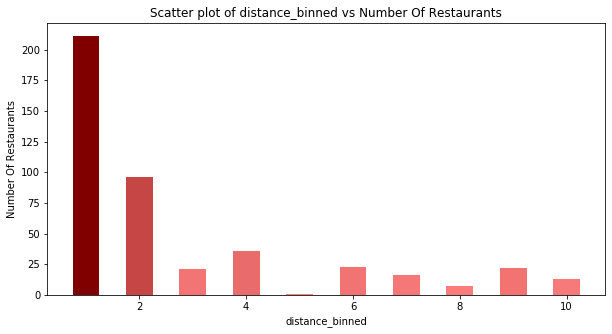

In [365]:
import matplotlib as mp
rcParams['figure.figsize'] = (10,5)
# Colorize the graph based on likeability:
likeability_scores = np.array(rest_sum['NumberOfRestaurants'])
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)
 
plt.bar(rest_sum['distance_binned'],rest_sum['NumberOfRestaurants'],width=0.5,color=color_map(data_normalizer(likeability_scores)))
plt.title("Scatter plot of distance_binned vs Number Of Restaurants")
plt.xlabel("distance_binned")
plt.ylabel("Number Of Restaurants")

As we can see in the above chart the number of restaurants are much higher in the first two bins. It is not a good selection. Let's change the number of bins to 100 and see how it works.

In [366]:
bins = np.linspace(min(toronto_data['distance']),max(toronto_data['distance']),101)
bins

array([0.32771574, 0.42343357, 0.5191514 , 0.61486923, 0.71058707,
       0.8063049 , 0.90202273, 0.99774056, 1.09345839, 1.18917622,
       1.28489406, 1.38061189, 1.47632972, 1.57204755, 1.66776538,
       1.76348321, 1.85920105, 1.95491888, 2.05063671, 2.14635454,
       2.24207237, 2.3377902 , 2.43350804, 2.52922587, 2.6249437 ,
       2.72066153, 2.81637936, 2.9120972 , 3.00781503, 3.10353286,
       3.19925069, 3.29496852, 3.39068635, 3.48640419, 3.58212202,
       3.67783985, 3.77355768, 3.86927551, 3.96499334, 4.06071118,
       4.15642901, 4.25214684, 4.34786467, 4.4435825 , 4.53930033,
       4.63501817, 4.730736  , 4.82645383, 4.92217166, 5.01788949,
       5.11360733, 5.20932516, 5.30504299, 5.40076082, 5.49647865,
       5.59219648, 5.68791432, 5.78363215, 5.87934998, 5.97506781,
       6.07078564, 6.16650347, 6.26222131, 6.35793914, 6.45365697,
       6.5493748 , 6.64509263, 6.74081046, 6.8365283 , 6.93224613,
       7.02796396, 7.12368179, 7.21939962, 7.31511746, 7.41083

In [367]:
group_names = list(np.arange(1,101))

In [368]:
toronto_data["distance_binned"] = pd.cut(toronto_data['distance'] , bins , labels=group_names , include_lowest=True)
toronto_data.shape

(55, 9)

In [369]:
rest_sum = toronto_data.groupby('distance_binned').NumberOfRestaurants.sum().to_frame().reset_index()

Text(0, 0.5, 'Number Of Restaurants')

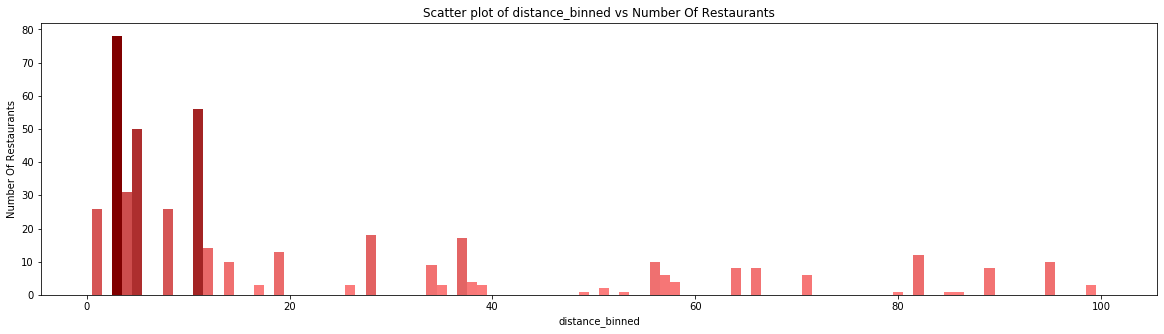

In [370]:
import matplotlib as mp
rcParams['figure.figsize'] = (20,5)
# Colorize the graph based on likeability:
likeability_scores = np.array(rest_sum['NumberOfRestaurants'])
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)
 
plt.bar(rest_sum['distance_binned'],rest_sum['NumberOfRestaurants'],width=1,color=color_map(data_normalizer(likeability_scores)))
plt.title("Scatter plot of distance_binned vs Number Of Restaurants")
plt.xlabel("distance_binned")
plt.ylabel("Number Of Restaurants")

Much better result. Let's continue with 100 bins for distance and 10 bins for number of restaurants.

* Since we prefer the lower grades for both elements, let's multiply them. The result is between 1 to 1000.
* 1 is the most desirable one. It has the lowest number of restaurants and the least distance.
* 1000 is the worst one. It has the highest number of restaurants and the most distance.
* In order to choose the optimal neighborhoods, only the ones that are selected as the proper locations whose results are 50 and lower 

In [371]:
proper_locations = toronto_data[(toronto_data.distance_binned.astype(int) * toronto_data.NumberOfRestaurants_binned.astype(int) <= 50)].reset_index(drop=True)
proper_locations

,PostalCode,Borough,Neighborhood,Latitude,Longitude,distance,NumberOfRestaurants,NumberOfRestaurants_binned,distance_binned
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.877023,3.0,1,17
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.078208,5.0,2,8
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.573854,25.0,8,3
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.720204,21.0,7,5
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.569449,20.0,7,3
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564,3.585122,3.0,1,35
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0.327716,26.0,8,1
7,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,5.000781,1.0,1,49
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0.726523,29.0,9,5
9,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,4.014044,2.0,1,39


## Cluster Neighborhoods

In order to find the best areas, the proper locations need to be clustered:

In [372]:
# set number of clusters
kclusters = 5

proper_locations_clustering = proper_locations[['Latitude','Longitude']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(proper_locations_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 2, 3, 2, 3, 4], dtype=int32)

In [373]:
# add clustering labels
proper_locations.insert(0, 'Cluster Labels', kmeans.labels_)
proper_locations.head()

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude,distance,NumberOfRestaurants,NumberOfRestaurants_binned,distance_binned
0,3,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.877023,3.0,1,17
1,3,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.078208,5.0,2,8
2,3,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.573854,25.0,8,3
3,3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.720204,21.0,7,5
4,3,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.569449,20.0,7,3


In [374]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(proper_locations['Latitude'], proper_locations['Longitude'], proper_locations['Neighborhood'], proper_locations['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion <a name="results"></a>

The result of our analysis shows 5 different areas that are the optimal locations for our restaurant:

1. East of university avenue in downtown
2. The area around Dupont street between Spadina and Dufferin
3. Toronto Island
4. Dufferin and King west
5. Mount Pleasant Rd, between St Clair and Bloor East

It is entirely possible that there is a very good reason for smaller number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Toronto areas close to center with low number of restaurants in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. By calculating number of restaurants in each neighborhood and considering their distance from the center of the city, first the best neighborhoods are nominated and then clustering of those locations was performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.